<a href="https://colab.research.google.com/github/neeravpatel10/GynoGlance/blob/main/PCOS_PCOS_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f418fc09-c23b-e4eb-9f0b-08578d67b1c5)


In [16]:
!pip install ultralytics

In [4]:
import ultralytics
print(ultralytics.__version__)

8.2.29


In [17]:
import warnings
warnings.filterwarnings("ignore")


import re
import glob
import random
import yaml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [18]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['no-pcos', 'pcos']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 10 # 100
    BATCH_SIZE = 4

    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e, yolo_nas_s, yolo_nas_m, yolo_nas_l
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'yolov8x{EPOCHS}_epochs'

    OPTIMIZER = 'Adam' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-5
    LR_FACTOR = 0.001
    WEIGHT_DECAY = 0.0005
    DROPOUT = 0.2
    PATIENCE = 10
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # pathsco
    CUSTOM_DATASET_DIR = '/content/drive/MyDrive/dataset'
    OUTPUT_DIR = '/content/drive/MyDrive/dataset'

In [19]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [20]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- no-pcos
- pcos
nc: 2
test: /content/drive/MyDrive/dataset/test
train: /content/drive/MyDrive/dataset/train
val: /content/drive/MyDrive/dataset/valid



In [21]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (224, 224, 3) 



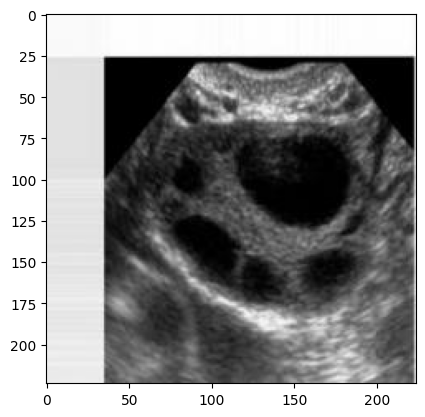

In [10]:
example_image_path = '/content/drive/MyDrive/dataset/train/images/img_0_1033_jpg.rf.e837430c9bd50f29559ffa3eb5b938ef.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [22]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread('/content/drive/MyDrive/dataset/train/images/img_0_1033_jpg.rf.e837430c9bd50f29559ffa3eb5b938ef.jpg')

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [23]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 224, 'height': 224, 'channels': 3, 'dtype': dtype('uint8')}

In [24]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 41.6 ms, sys: 24.6 ms, total: 66.2 ms
Wall time: 848 ms


,Mode,no-pcos,pcos,Data_Volume
0,train,61,103,164
1,valid,13,10,23
2,test,27,20,47


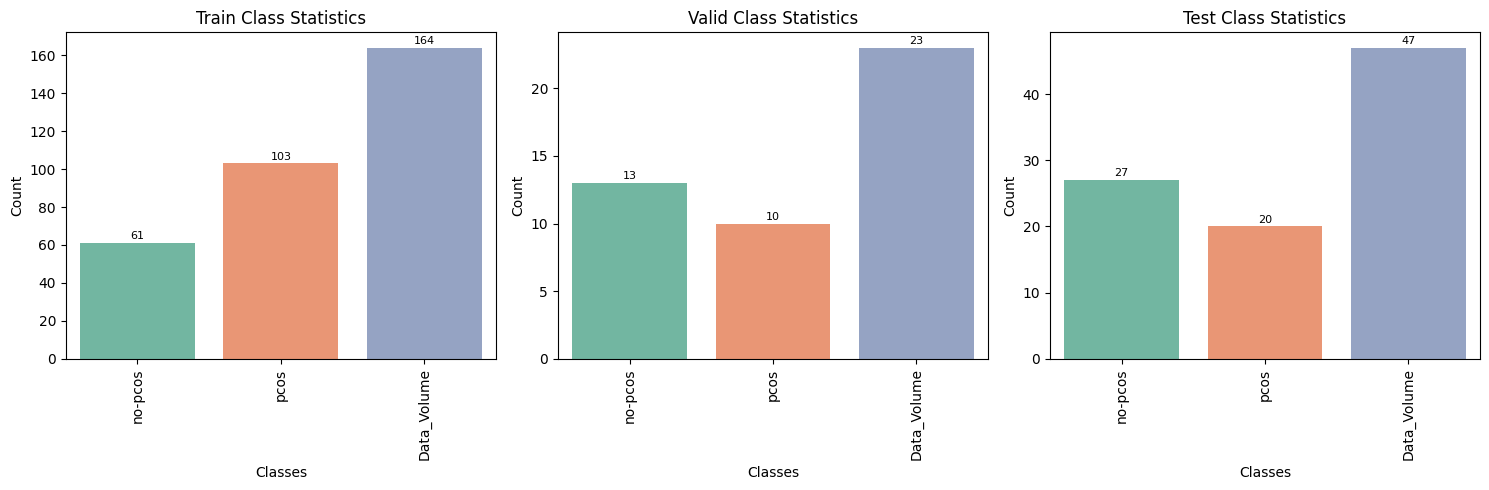

In [25]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [26]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(224, 224)



Image sizes in valid set:
(224, 224)



Image sizes in test set:
(224, 224)


CPU times: user 63.2 ms, sys: 32.5 ms, total: 95.8 ms
Wall time: 910 ms


In [27]:
CFG.BASE_MODEL_WEIGHTS

'yolov8x.pt'

In [28]:
import torch
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  10
Batch:  4


In [30]:
import os
import pickle

# Define the configuration
train_config = {
    'data': os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    'task': 'detect',
    'imgsz': (img_properties['height'], img_properties['width']),
    'epochs': CFG.EPOCHS,
    'batch': CFG.BATCH_SIZE,
    'optimizer': CFG.OPTIMIZER,
    'lr0': CFG.LR,
    'lrf': CFG.LR_FACTOR,
    'weight_decay': CFG.WEIGHT_DECAY,
    'dropout': CFG.DROPOUT,
    'fraction': CFG.FRACTION,
    'patience': CFG.PATIENCE,
    'profile': CFG.PROFILE,
    'label_smoothing': CFG.LABEL_SMOOTHING,
    'name': f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    'seed': CFG.SEED,
    'val': True,
    'amp': True,
    'exist_ok': True,
    'resume': False,
    'device': 0, # Set to single GPU device
    'verbose': False,
}

# Save the configuration
config_file = os.path.join(CFG.OUTPUT_DIR, '/content/drive/MyDrive/dataset/train_config.pkl')
with open(config_file, 'wb') as f:
    pickle.dump(train_config, f)

# Load the configuration
with open(config_file, 'rb') as f:
    loaded_config = pickle.load(f)

# Train the model using the loaded configuration
model.train(**loaded_config)


Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=10, time=None, patience=10, batch=4, imgsz=(224, 224), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_yolov8x10_epochs, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8x_yolov8x10_epochs/labels.jpg... 
optimizer: Adam(lr=1e-05, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8x_yolov8x10_epochs
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.01G      1.531      2.311      1.945          4        224: 100%|██████████| 41/41 [00:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         23         23       0.43      0.827      0.554      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.04G      1.156      1.389      1.484          4        224: 100%|██████████| 41/41 [00:07<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.74it/s]

                   all         23         23      0.699      0.862      0.848      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.05G      1.077      1.023      1.455          4        224: 100%|██████████| 41/41 [00:05<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         23         23      0.752      0.938      0.941      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.05G      1.024      1.006      1.421          4        224: 100%|██████████| 41/41 [00:06<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.58it/s]

                   all         23         23      0.901      0.967      0.986      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.05G      0.994     0.8058       1.38          4        224: 100%|██████████| 41/41 [00:06<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]

                   all         23         23      0.986      0.972      0.995      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.05G     0.9819     0.7675      1.366          4        224: 100%|██████████| 41/41 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]

                   all         23         23      0.986      0.996      0.995      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.05G     0.9728      0.748      1.357          4        224: 100%|██████████| 41/41 [00:06<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         23         23      0.994          1      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.05G     0.9216     0.7077      1.335          4        224: 100%|██████████| 41/41 [00:07<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         23         23      0.984          1      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.05G     0.9208     0.6887      1.318          4        224: 100%|██████████| 41/41 [00:05<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.22it/s]

                   all         23         23      0.993          1      0.995      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.05G     0.9532     0.6687       1.32          4        224: 100%|██████████| 41/41 [00:05<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

                   all         23         23      0.988          1      0.995      0.764



10 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/yolov8x_yolov8x10_epochs/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8x_yolov8x10_epochs/weights/best.pt, 136.7MB

Validating runs/detect/yolov8x_yolov8x10_epochs/weights/best.pt...
Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


                   all         23         23      0.986      0.972      0.995      0.766
Speed: 1.1ms preprocess, 13.7ms inference, 0.0ms loss, 9.7ms postprocess per image
Results saved to runs/detect/yolov8x_yolov8x10_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f881d006c50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (768, 768, 3) 



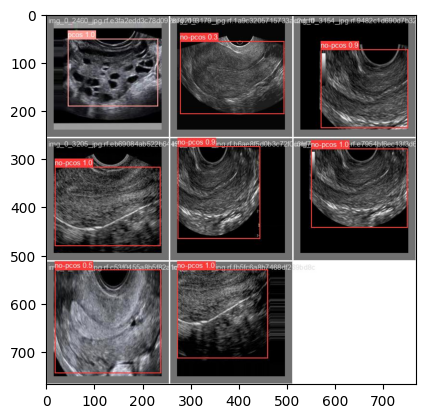

In [32]:
example_image_path = '/content/runs/detect/yolov8x_yolov8x10_epochs/val_batch0_pred.jpg'
display_image(example_image_path)

In [36]:
import joblib
img_properties
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths
%matplotlib inline
# Loading the best performing model
model = YOLO('/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.pt')
joblib(model,'/content/drive/MyDrive/trained_model.pkl')
metrics = model.val(data='/content/drive/MyDrive/dataset/data.yaml', split = 'test')

Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 6, 1029) (130.3 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 44.0s, saved as '/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.onnx' (260.0 MB)

Export complete (46.6s)
Results saved to /content/runs/detect/yolov8x_yolov8x10_epochs/weights
Predict:         yolo predict task=detect model=/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.onnx imgsz=224  
Validate:        yolo val task=detect model=/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.onnx imgsz=224 data=/content/drive/MyDrive/dataset/data.yaml  
Visualize:       https://netron.app


TypeError: 'module' object is not callable

In [37]:
# Import necessary libraries
from ultralytics import YOLO
import joblib
import torch

# Load the best performing model
model = YOLO('/content/runs/detect/yolov8x_yolov8x10_epochs/weights/best.pt')

# Save the model using joblib
joblib.dump(model, '/content/drive/MyDrive/trained_model.pkl')

# Example to validate the model (not necessary for saving)
metrics = model.val(data='/content/drive/MyDrive/dataset/data.yaml', split='test')


Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/drive/MyDrive/dataset/test/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


                   all         47         47      0.772      0.821      0.864      0.583
               no-pcos         27         27      0.678          1      0.881        0.6
                  pcos         20         20      0.865      0.641      0.848      0.566
Speed: 0.1ms preprocess, 11.8ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/val2



image 1/1 /content/drive/MyDrive/dataset/WhatsApp Image 2024-06-09 at 09.50.49_dc73ad58.jpg: 224x224 1 pcos, 1111.7ms
Speed: 2.2ms preprocess, 1111.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 224)


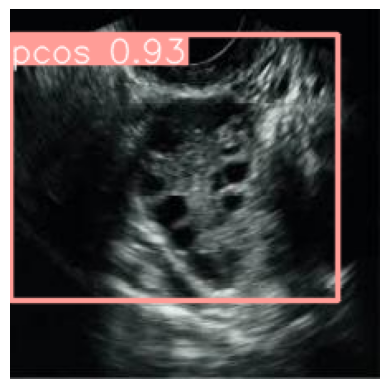

In [5]:
# Import the necessary libraries
!pip install ultralytics

import joblib
import matplotlib.pyplot as plt
import cv2

# Load the best performing model
model = joblib.load('/content/drive/MyDrive/trained_model.pkl')

# Path to your test image
image_path = '/content/drive/MyDrive/dataset/WhatsApp Image 2024-06-09 at 09.50.49_dc73ad58.jpg'
# Run inference on the single image
results = model.predict(source=image_path, save=False, show=False)

# Get the first result (assuming one image)
result = results[0]

# Convert the result to an OpenCV image
result_image = result.plot()

# Convert BGR image to RGB for displaying with Matplotlib
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the image with detections
plt.imshow(result_image_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [1]:
from flask import Flask, request, send_file, jsonify
import joblib
from PIL import Image
import numpy as np
import io
import logging
from pyngrok import ngrok
import cv2
from ultralytics import YOLO

app = Flask(__name__)

# Set your ngrok authtoken
ngrok.set_auth_token("your-authtoken")

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

# Load your trained YOLO model
model = YOLO('/content/drive/MyDrive/trained_model.pkl')

def preprocess_image(image):
    logging.info(f"Original image mode: {image.mode}, size: {image.size}")

    # Convert the image to RGB
    image = image.convert("RGB")
    logging.info(f"Converted to RGB mode: {image.mode}, size: {image.size}")

    # Resize the image to the expected input size of the model
    target_size = (640, 640)  # Adjust the target size as needed
    image = image.resize(target_size)
    logging.info(f"Resized image size: {image.size}")

    # Convert the image to a numpy array
    image_np = np.array(image)
    logging.info(f"Resized image shape: {image_np.shape}")

    # Normalize the pixel values to [0, 1]
    image_np = image_np / 255.0
    logging.info(f"Normalized image array shape: {image_np.shape}, values: {image_np}")

    # Ensure the image is 3-dimensional
    if len(image_np.shape) == 2:
        image_np = np.stack((image_np,)*3, axis=-1)
        logging.info(f"Image converted to 3D: {image_np.shape}")

    # Expand dimensions to create a batch of size 1
    image_np = np.expand_dims(image_np, axis=0)
    logging.info(f"Image shape after expanding dims: {image_np.shape}")

    return image_np

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        image = Image.open(file.stream)
        logging.info(f"Loaded image size: {image.size}, mode: {image.mode}")

        # Preprocess the image
        preprocessed_image = preprocess_image(image)

        # Verify that the image has valid dimensions
        if preprocessed_image.shape[1] <= 0 or preprocessed_image.shape[2] <= 0 or preprocessed_image.shape[3] <= 0:
            logging.error("Invalid image dimensions before prediction")
            raise ValueError("Invalid image dimensions before prediction")

        # Debug: log the final shape before prediction
        logging.info(f"Preprocessed image shape: {preprocessed_image.shape}")

        # Perform prediction
        results = model.predict(source=preprocessed_image, save=False, show=False)
        logging.info(f"Model prediction results: {results}")

        # Get the first result (assuming one image)
        result = results[0]

        # Convert the result to an OpenCV image
        result_image = result.plot()

        # Convert BGR image to RGB for displaying with Matplotlib
        result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

        # Save the result image to a BytesIO object
        img_io = io.BytesIO()
        result_pil_image = Image.fromarray(result_image_rgb)
        result_pil_image.save(img_io, 'JPEG', quality=70)
        img_io.seek(0)

        return send_file(img_io, mimetype='image/jpeg')
    except Exception as e:
        logging.exception("Error during image prediction")
        return jsonify(error=str(e)), 500

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    print(f"Starting Flask server on {public_url}")
    app.run(port=5000)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


ModuleNotFoundError: No module named 'ultralytics'

In [1]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

import os
os.environ['LANG'] = 'en_US.UTF-8'


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [2]:
!pip install pyngrok


In [ ]:
from flask import Flask, request, send_file, jsonify
import joblib
from PIL import Image
import numpy as np
import io
import logging
from pyngrok import ngrok
import cv2

app = Flask(__name__)

# Set your ngrok authtoken
ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN")

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

# Load your trained model
model = joblib.load('/content/drive/MyDrive/trained_model.pkl')

def preprocess_image(image):
    logging.info(f"Original image mode: {image.mode}, size: {image.size}")

    # Convert the image to RGB
    image = image.convert("RGB")
    logging.info(f"Converted to RGB mode: {image.mode}, size: {image.size}")

    # Resize the image to the expected input size of the model
    target_size = (224, 224)  # Replace with the correct size for your model
    image = image.resize(target_size)
    logging.info(f"Resized image size: {image.size}")

    # Convert the image to a numpy array
    image_np = np.array(image)
    logging.info(f"Resized image shape: {image_np.shape}")

    # Normalize the pixel values to [0, 1]
    image_np = image_np / 255.0
    logging.info(f"Normalized image array shape: {image_np.shape}, values: {image_np[:5]}")

    # Ensure the image is 3-dimensional
    if len(image_np.shape) == 2:
        image_np = np.stack((image_np,) * 3, axis=-1)
        logging.info(f"Image converted to 3D: {image_np.shape}")
    elif image_np.shape[2] == 1:
        image_np = np.concatenate([image_np] * 3, axis=-1)
        logging.info(f"Grayscale image converted to 3 channels: {image_np.shape}")

    # Expand dimensions to create a batch of size 1
    image_np = np.expand_dims(image_np, axis=0)
    logging.info(f"Image shape after expanding dims: {image_np.shape}")

    # Verify image dimensions before returning
    if image_np.shape[1] <= 0 or image_np.shape[2] <= 0 or image_np.shape[3] <= 0:
        logging.error("Invalid image dimensions after preprocessing")
        raise ValueError("Invalid image dimensions after preprocessing")

    return image_np

@app.route('/test')
def hello_world():
    return 'Hello, World!'

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        image = Image.open(file.stream)
        logging.info(f"Loaded image size: {image.size}, mode: {image.mode}")

        # Preprocess the image
        preprocessed_image = preprocess_image(image)

        # Verify that the image has valid dimensions
        if preprocessed_image.shape[1] <= 0 or preprocessed_image.shape[2] <= 0 or preprocessed_image.shape[3] <= 0:
            logging.error("Invalid image dimensions before prediction")
            raise ValueError("Invalid image dimensions before prediction")

        # Debug: log the final shape before prediction
        logging.info(f"Preprocessed image shape: {preprocessed_image.shape}")

        # Perform prediction
        results = model.predict(preprocessed_image)
        logging.info(f"Model prediction results: {results}")

        # If results need further processing to convert back to an image
        if isinstance(results, list):
            results = results[0]

        # Convert back to image
        result_image = Image.fromarray((results * 255).astype(np.uint8))

        img_io = io.BytesIO()
        result_image.save(img_io, 'JPEG', quality=70)
        img_io.seek(0)

        return send_file(img_io, mimetype='image/jpeg')
    except Exception as e:
        logging.exception("Error during image prediction")
        return jsonify(error=str(e)), 500

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    print(f"Starting Flask server on {public_url}")
    app.run(port=5000)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
